In [1]:
from dataclasses import dataclass
import random
from math import sin, cos, sqrt, atan2, pi

import matplotlib.pyplot as plt
import numpy as np

from robot_child.path_following.pure_pursuit import Robot, Point, PointController, PurePursuitController

In [38]:
STEPS_PER_SECOND = 10
dt = 1/STEPS_PER_SECOND

def plot_history(ax, points, history):
    for p in points:
        ax.plot(p.x, p.y, 'r*')
    ax.plot(history[:, 0], history[:, 1], '.-')

    # for row in history:
    #     ax.plot(row[0], row[1], marker=(3, 1, 180+np.rad2deg(row[2])), color='b')

@dataclass
class RobotMecanum:
    # coordinates with respect to the world frame
    x: float = 0
    y: float = 0
    theta: float = 0 # radians

    vf: float = 0
    vs: float = 0
    w: float = 0

    def step(self, dt):
        assert self.vs == 0
        self.x += self.vf * cos(self.theta) * dt
        self.y += self.vf * sin(self.theta) * dt
        self.theta += self.w * dt
        return self
    # def step(self, dt):
    #     self.x += self.vf * cos(self.theta) * dt
    #     self.y += self.vf * sin(self.theta) * dt
    #     self.theta += self.angular_velocity * dt
    #     return self

    @property
    def velocity(self):
        return self.vf

    @property
    def angular_velocity(self):
        return self.w

    @velocity.setter
    def velocity(self, value):
        self.vf = value

    @angular_velocity.setter
    def angular_velocity(self, value):
        self.w = value

def simulate(dt, robot, controller, steps_max):
    history = []
    steps_taken = 0
    while not controller.is_complete(robot):
        robot.velocity, robot.angular_velocity = controller.control(robot, dt)
        robot.step(dt)
        steps_taken += 1
        history.append((robot.x, robot.y, robot.theta, robot.velocity, robot.angular_velocity))
        if steps_taken >= steps_max:
            return False, np.array(history)
    return True, np.array(history)

points = [Point(0, 0)]
for step in range(1, 6):
    points.append(Point(step*10, random.uniform(-1, 1)))

bots = {
    "differential": Robot(x=0, y=0),
    "mecanum": RobotMecanum(x=0, y=0)
}

histories = {}
for name, bot in bots.items():
    point_controller = PointController(tolerance=0.5)
    path_controller = PurePursuitController(point_controller=point_controller, points=points)
    
    status, history = simulate(dt, bot, path_controller, 2000)   
    histories[name] = history

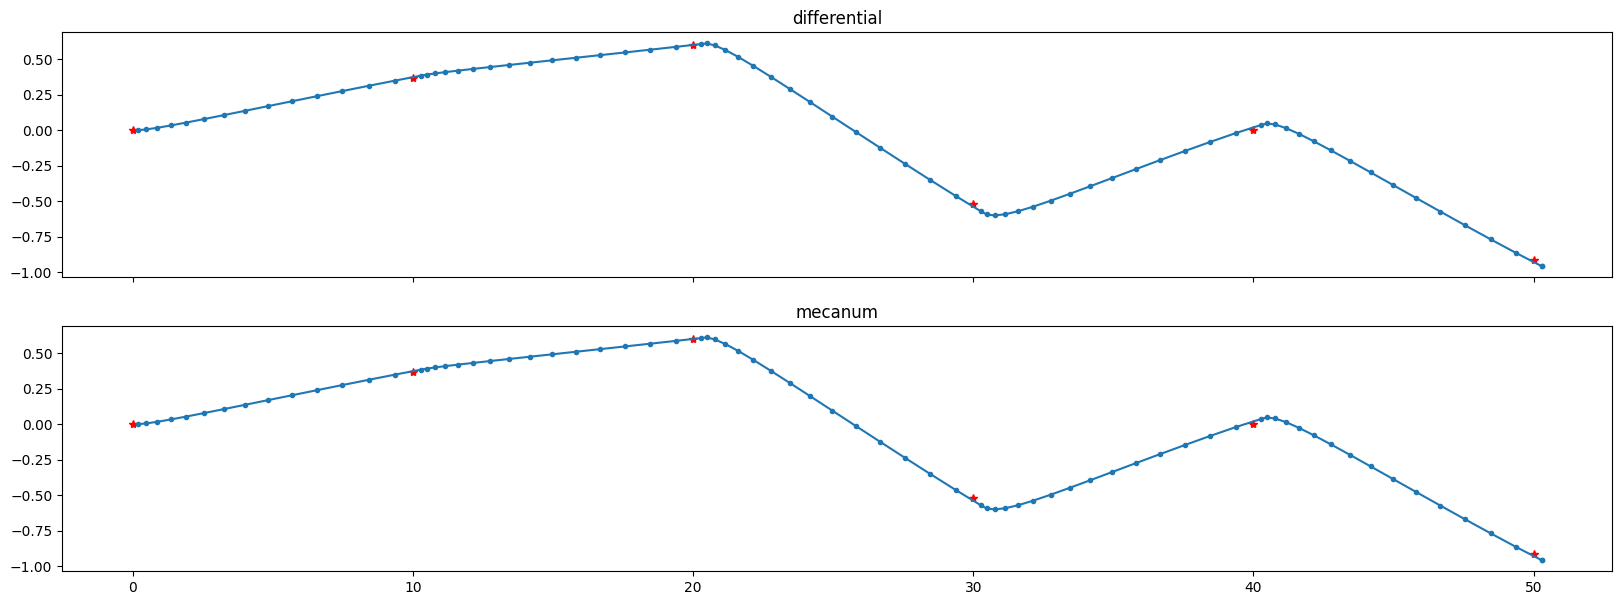

In [39]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 7))
for ax, (name, history) in zip(axes, histories.items()):
    ax.set_title(name)
    plot_history(ax, points, history)